Используемые источники:

* [Первая глава диссертации об общих подходах к прогнозированию и оценки uplift](http://www.maths.ed.ac.uk/~mthdat25/uplift/MesallesNaranjoOscar-1)
* [Статья о подходах к прогнозированию ulpift](http://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf)
* [Статья, в которой неплохо описаны способы оценок uplift](http://stochasticsolutions.com/pdf/sig-based-up-trees.pdf)
* [Репозиторий на github с некоторыми подходами к прогнозированию и оценке uplift](https://github.com/PGuti/Uplift)

In [1]:
%load_ext autoreload
%autoreload 2

In [152]:
import pandas as pd
import numpy as np
import codecs

# from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as image

import sys
sys.path.append('./')
from utils import Dummyfier, prepare, evaluate_clf, uplift

from IPython.core.debugger import set_trace

# import seaborn.apionly as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
df = pd.read_csv('./train_data/train_dataset.csv', sep='>', na_values='<null>', 
                 parse_dates=['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Dataset size: ', df.shape)
df.head(2)

Dataset size:  (114720, 215)


,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,273-P-99431598,105098373,N,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,274-P-23967129,101763714,N,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df['TARGET'].value_counts(normalize=True)

0    0.955483
1    0.044517
Name: TARGET, dtype: float64

In [20]:
df['CONTROL_GROUP_FLG'].value_counts(normalize=True)

N    0.849433
Y    0.150567
Name: CONTROL_GROUP_FLG, dtype: float64

In [19]:
df.groupby('CONTROL_GROUP_FLG').mean()[['TARGET']]

,TARGET
CONTROL_GROUP_FLG,
N,0.047636
Y,0.026921


# 1 Построение одной модели для тестовой и контрольной групп

In [65]:
Xy_train, Xy_val = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['TARGET'])

dummy = [u'CL_FAM_ST', u'CL_OFF_POS', u'CL_OWN_TYPE', u'LAST_CARD_STATUS', 'CL_ESTATE_TYPE', 
         'CL_INDUSTR', 'CL_SOC_ST', 'ZODIAC']
d = Dummyfier(dummy, drop_old=True)

Xy_train = prepare(Xy_train)

Xy_train = d.fit_transform(Xy_train)

In [155]:
Xy_train['CONTROL_GROUP_FLG'].value_counts(dropna=False, normalize=True)

0    0.849634
1    0.150366
Name: CONTROL_GROUP_FLG, dtype: float64

In [156]:
Xy_val['CONTROL_GROUP_FLG'].value_counts(dropna=False, normalize=True)

N    0.848631
Y    0.151369
Name: CONTROL_GROUP_FLG, dtype: float64

In [69]:
#Xy_train.iloc[:,100:120]

In [44]:
Xy_train, Xy_val = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['TARGET'])

dummy = [u'CL_FAM_ST', u'CL_OFF_POS', u'CL_OWN_TYPE', u'LAST_CARD_STATUS', 'CL_ESTATE_TYPE', 
         'CL_INDUSTR', 'CL_SOC_ST', 'ZODIAC']
d = Dummyfier(dummy, drop_old=True)

Xy_train = prepare(Xy_train)
Xy_train = d.fit_transform(Xy_train)

na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
Xy_train = Xy_train.fillna(value=Xy_train[na_cols_train].mean())

Xy_val = prepare(Xy_val)
Xy_val = d.transform(Xy_val)

na_cols_val = Xy_val.isna().any()
na_cols_val = na_cols_val[na_cols_val==True].index.tolist()
Xy_val = Xy_val.fillna(value=Xy_val[na_cols_val].mean())

y_train, y_val = Xy_train['TARGET'].values.flatten(), Xy_val['TARGET'].values.flatten()

identity = ['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME_UNI', 'START_DATE']
X_train, X_val = Xy_train.drop(['TARGET'] + identity, axis=1), Xy_val.drop(['TARGET'] + identity, axis=1)

In [45]:
print(X_train.shape)
print(X_val.shape)

(91776, 140)
(22944, 140)


In [49]:
#X_train.iloc[:,10:20]
X_train['FL_GOLD'].value_counts() 
X_train['CL_AUTO_EX'].value_counts() 
# 3 different values for binaries
# Because of nan values - ?

0.000000    55238
1.000000    22050
0.285297    14488
Name: CL_AUTO_EX, dtype: int64

In [37]:
set(X_train.columns)==set(X_val.columns)

True

In [43]:
X_train.columns[:20]

Index(['CONTROL_GROUP_FLG', 'BAL', 'CARD_CONTR_COUNT_0', 'CARD_STATUS_14',
       'CARD_STATUS_176', 'CL_AMT_DOP', 'CL_AMT_ZP', 'CL_AUTO_EX', 'CL_EDU',
       'CODE_67_MAX_180', 'CODE_67_MEAN_180', 'CODE_67_N_180', 'FL_4P',
       'FL_DOC_PROFIT', 'FL_FRGN_TRIP', 'FL_FRNG_PASSP', 'FL_GOLD', 'FL_MOBB',
       'FL_P24', 'FL_PENS'],
      dtype='object')

In [38]:
scaler = StandardScaler()

X_train_sc = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_sc = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

In [96]:
Xy_train.index == 60357

Int64Index([ 60357,  56477,  55833,  18824,  62838, 114626, 103185,  27782,
             55476,  76044,
            ...
             20392,  45180,  36091,  34972,  73696,  47216,  92083,  84386,
             78814,  35399],
           dtype='int64', length=91776)

In [102]:
a1 = Xy_train[Xy_train.index==60357]
a2 = Xy_train[Xy_train.index==56477]
c = pd.concat([a1,a2])
c['CL_AMT_DOP']

60357    0.0
56477    0.0
Name: CL_AMT_DOP, dtype: float64

In [81]:
#X_train_sc['BAL'].std()
#X_train_sc['CONTROL_GROUP_FLG'].std()

In [104]:
#60357
#56477

In [109]:
X_train.columns[100:120]

Index(['CL_INDUSTR_dummy_NA', 'CL_INDUSTR_dummy_TRADE',
       'CL_INDUSTR_dummy_CONSTRUCTION', 'CL_INDUSTR_dummy_HEALTH',
       'CL_INDUSTR_dummy_LIGHTINDUSTRIES', 'CL_INDUSTR_dummy_SERVICESECTOR',
       'CL_INDUSTR_dummy_ETC', 'CL_INDUSTR_dummy_EDUCATION',
       'CL_INDUSTR_dummy_UTILITIES', 'CL_INDUSTR_dummy_LEGALSERVICES',
       'CL_INDUSTR_dummy_ENGINEERING', 'CL_INDUSTR_dummy_BANKS',
       'CL_INDUSTR_dummy_CIVILSERVANTS', 'CL_INDUSTR_dummy_AGRICULTURE',
       'CL_INDUSTR_dummy_IT', 'CL_INDUSTR_dummy_TRANSPORTATION',
       'CL_INDUSTR_dummy_ARMEDFORCES', 'CL_INDUSTR_dummy_FUELCOMPLEX',
       'CL_INDUSTR_dummy_METALLURGY', 'CL_INDUSTR_dummy_TOURISM'],
      dtype='object')

                 train     valid
ROC AUC       0.669095  0.682539
Av Precision  0.094886  0.100687
logloss       0.175282  0.173994
Accuracy      0.924000  0.925819
Precision     0.146389  0.166503
Precision@10  0.121949  0.123419
Recall        0.146353  0.166503
F1            0.146371  0.166503
F0.5          0.146382  0.166503
F2            0.146361  0.166503


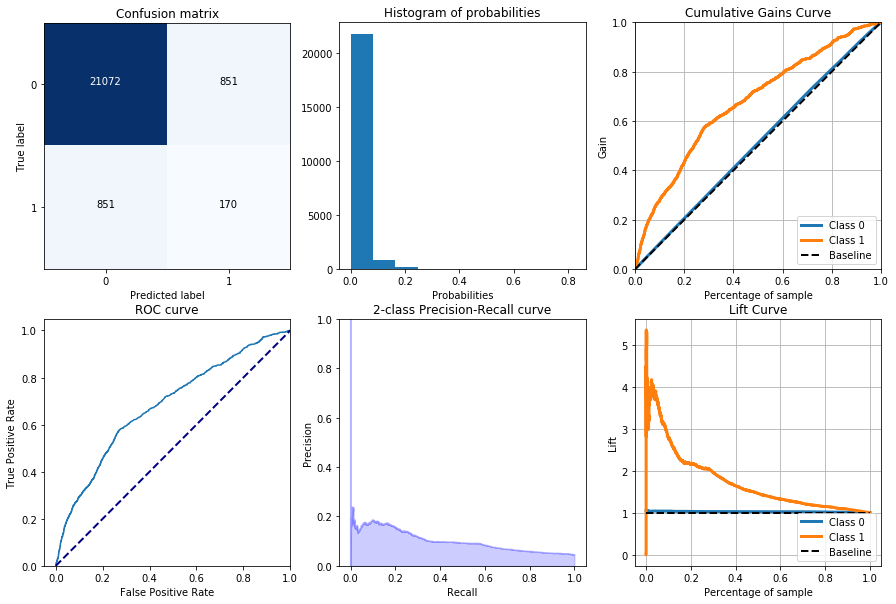

In [151]:
cols_to_try = [ 'CONTROL_GROUP_FLG', 'BAL', 'AGE', 'TOTAL_SUM_180', 
               'TOTAL_BAL_NEG_CHNG_N_90', 'CL_FAM_ST_dummy_MARRIED']
# change C does not change metris!
lr1 = LogisticRegression(C=0.1, penalty='l2')
lr1_model = evaluate_clf(lr1, X_train_sc[cols_to_try], y_train, X_val_sc[cols_to_try], y_val)
#lr1_model = evaluate_clf(lr1, X_train_sc[['AGE','CONTROL_GROUP_FLG']], y_train, X_val_sc[['AGE','CONTROL_GROUP_FLG']],
#                                         y_val)

                 train     valid
ROC AUC       0.768936  0.777126
Av Precision  0.118495  0.126925
logloss       0.173785  0.172928
Accuracy      0.924239  0.925645
Precision     0.149082  0.164545
Precision@10  0.138187  0.141736
Recall        0.149046  0.164545
F1            0.149064  0.164545
F0.5          0.149075  0.164545
F2            0.149053  0.164545


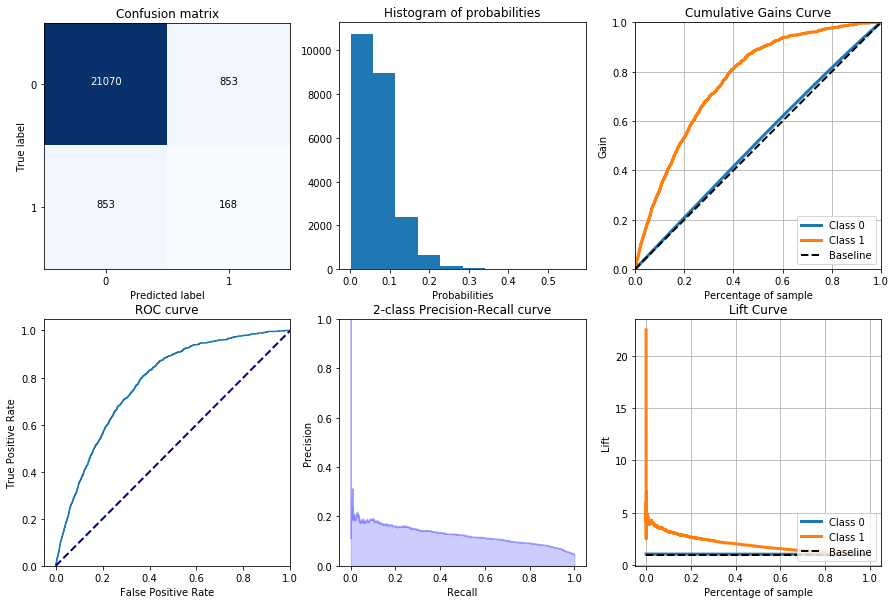

Wall time: 3.71 s


In [140]:
%%time

lr = LogisticRegression(C=0.001)

lr_model, _ = evaluate_clf(lr, X_train_sc, y_train, X_val_sc, y_val)

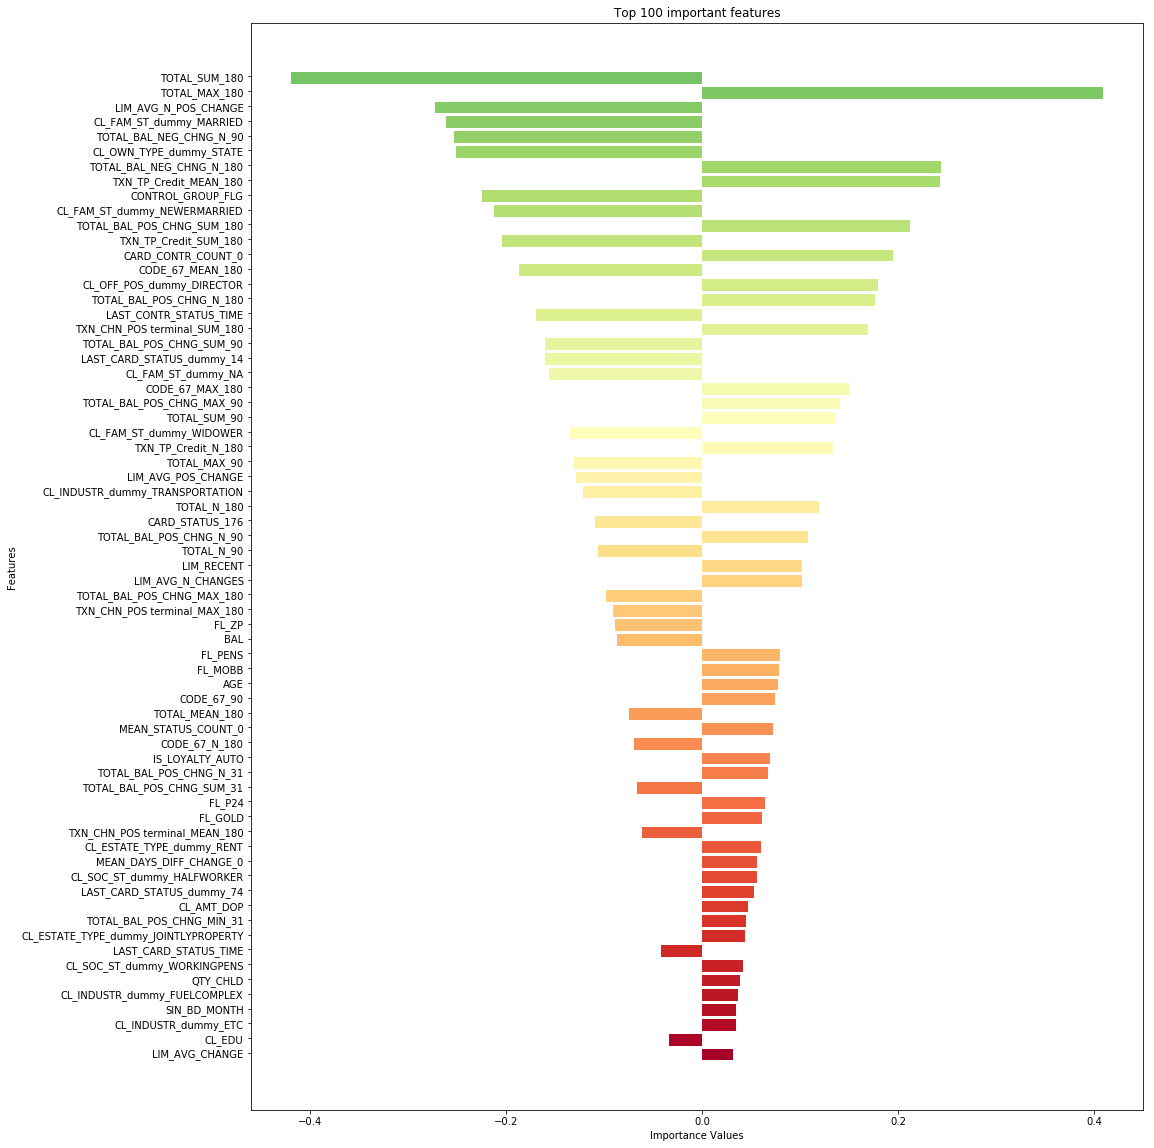

In [9]:
importances = pd.DataFrame(data={
    'features': X_train_sc.columns,
    'fscore': lr_model.coef_[0]
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

## Оценим UPLIFT

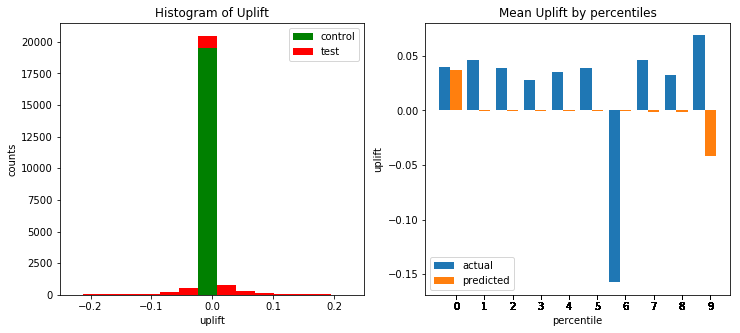

In [10]:
# Клиенты с реальными значениями флага_кг
evaluate1 =  X_val_sc.copy()
evaluate1['TARGET'] = y_val
evaluate1['real'] = True

# Клиенты с инверсионными значениями флага_кг
evaluate2 = X_val.copy()

evaluate2['CONTROL_GROUP_FLG'] = 1 - evaluate2['CONTROL_GROUP_FLG']

evaluate2 = pd.DataFrame(
    scaler.transform(evaluate2),
    columns=evaluate2.columns,
    index=evaluate2.index
)

evaluate2['real'] = False

for_model = pd.concat([evaluate1, evaluate2])
del evaluate1, evaluate2

for_model = for_model.reset_index().sort_values(['index', 'CONTROL_GROUP_FLG'], ascending=[False, True]).set_index('index')

for_model['not_sent'] = lr_model.predict_proba(for_model.drop(['real', 'TARGET'], axis=1))[:, 1]
for_model['sent'] = for_model['not_sent'].shift(-1)
for_model['uplift'] = for_model['sent'] - for_model['not_sent']
# оценим uplift
evaluate =Xy_val.copy()
evaluate['not_sent'] = for_model[for_model['real']==True]['not_sent']
evaluate['sent'] = for_model[for_model['real']==True]['sent']
evaluate['uplift'] = for_model[for_model['real']==True]['uplift']

evaluate['predict'] = np.floor(evaluate.uplift.rank(method='first', ascending = False) /\
                                            (evaluate.shape[0]+1) * 10)

eval_actual = pd.crosstab(index=evaluate['predict'].astype(int), columns=evaluate['CONTROL_GROUP_FLG'], 
            values=evaluate['TARGET'], aggfunc='mean')
eval_actual['uplift'] = eval_actual[0] - eval_actual[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].title.set_text('Histogram of Uplift')
axes[0].hist([evaluate[evaluate['CONTROL_GROUP_FLG']==0]['uplift'],
          evaluate[evaluate['CONTROL_GROUP_FLG']==1]['uplift']],
         stacked=True, label=['control', 'test'], bins=50, color=['g', 'r'])
ss
axes[0].set_xlabel('uplift')
axes[0].set_ylabel('counts')
axes[0].set_xlim([-0.25, 0.25])
axes[0].legend()


axes[1].bar(eval_actual.index-0.4, eval_actual['uplift'], label='actual', width = 0.4)
axes[1].bar(evaluate.groupby('predict').mean().index, 
        evaluate.groupby('predict').mean()['uplift'], label='predicted', width=0.4)
axes[1].set_xticks(evaluate['predict'])
axes[1].set_xlabel('percentile')
axes[1].set_ylabel('uplift')
axes[1].legend()
axes[1].title.set_text('Mean Uplift by percentiles')

In [11]:
eval_actual

CONTROL_GROUP_FLG,0,1,uplift
predict,,,
0,0.062057,0.021965,0.040091
1,0.045892,0.000000,0.045892
2,0.039250,0.000000,0.039250
3,0.027923,0.000000,0.027923
4,0.034889,0.000000,0.034889
5,0.038445,0.000000,0.038445
6,0.042451,0.200000,-0.157549
7,0.046073,0.000000,0.046073
8,0.085512,0.052632,0.032880


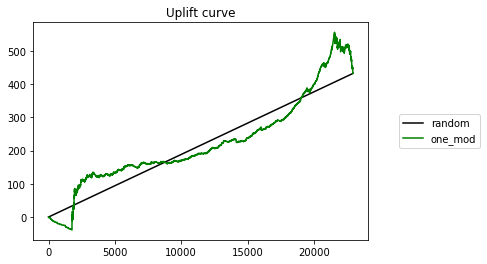

In [12]:
one_mod_uc = uplift(evaluate, 'CONTROL_GROUP_FLG', 'TARGET', 'uplift')

rd_uc = (evaluate[evaluate['CONTROL_GROUP_FLG']==0]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==0].shape[0]
        - evaluate[evaluate['CONTROL_GROUP_FLG']==1]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==1].shape[0])
rd = np.arange(evaluate.shape[0]) * rd_uc

plt.title('Uplift curve')
plt.plot(np.arange(evaluate.shape[0]), rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), one_mod_uc, color = 'g', label = 'one_mod')
plt.legend(bbox_to_anchor=(1.35, 0.6))

# 2 Построение двух моделей

In [13]:
X_train_c = Xy_train[Xy_train['CONTROL_GROUP_FLG']==1].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_train_c = Xy_train[Xy_train['CONTROL_GROUP_FLG']==1]['TARGET'].values.flatten()
X_val_c = Xy_val[Xy_val['CONTROL_GROUP_FLG']==1].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_val_c = Xy_val[Xy_val['CONTROL_GROUP_FLG']==1]['TARGET'].values.flatten()

X_train_t = Xy_train[Xy_train['CONTROL_GROUP_FLG']==0].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_train_t = Xy_train[Xy_train['CONTROL_GROUP_FLG']==0]['TARGET'].values.flatten()
X_val_t = Xy_val[Xy_val['CONTROL_GROUP_FLG']==0].drop(['TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
y_val_t = Xy_val[Xy_val['CONTROL_GROUP_FLG']==0]['TARGET'].values.flatten()

In [14]:
scaler_c = StandardScaler()

X_train_c_sc = pd.DataFrame(
    scaler_c.fit_transform(X_train_c),
    columns=X_train_c.columns,
    index=X_train_c.index
)

X_val_c_sc = pd.DataFrame(
    scaler_c.transform(X_val_c),
    columns=X_val_c.columns,
    index=X_val_c.index
)

In [15]:
scaler_t = StandardScaler()

X_train_t_sc = pd.DataFrame(
    scaler_t.fit_transform(X_train_t),
    columns=X_train_t.columns,
    index=X_train_t.index
)

X_val_t_sc = pd.DataFrame(
    scaler_t.transform(X_val_t),
    columns=X_val_t.columns,
    index=X_val_t.index
)

                 train     valid
ROC AUC       0.814530  0.785391
Av Precision  0.130029  0.118136
logloss       0.103877  0.116293
Accuracy      0.956812  0.954794
Precision     0.185792  0.184783
Precision@10  0.122553  0.112717
Recall        0.185792  0.171717
F1            0.185792  0.178010
F0.5          0.185792  0.182013
F2            0.185792  0.174180


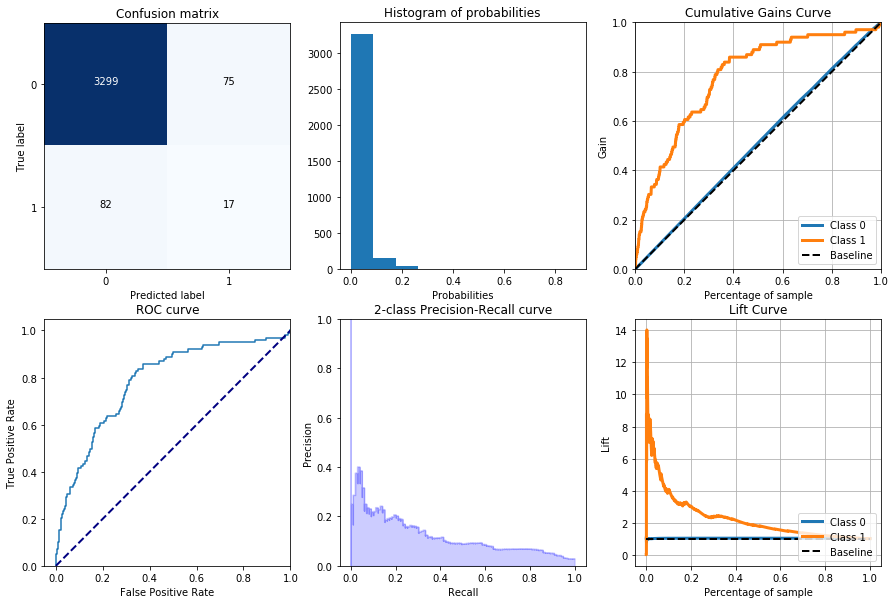

In [16]:
lr_c = LogisticRegression()

lr_model_c, c_prob = evaluate_clf(lr_c, X_train_c_sc, y_train_c, X_val_c_sc, y_val_c)

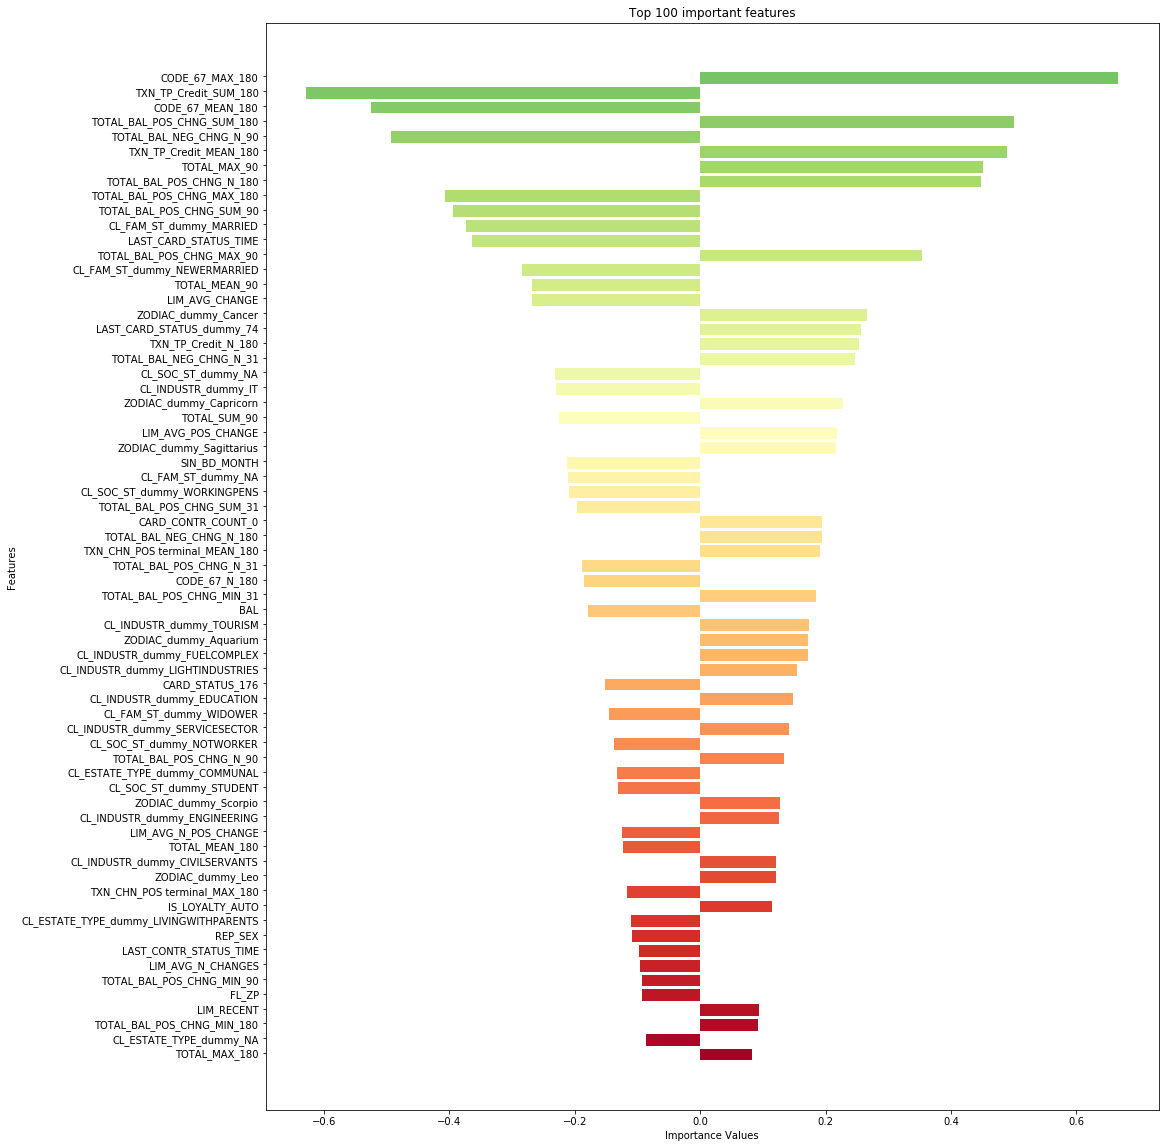

In [17]:
importances = pd.DataFrame(data={
    'features': X_train_c.columns,
    'fscore': lr_model_c.coef_[0]
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

                 train     valid
ROC AUC       0.761401  0.764133
Av Precision  0.124060  0.128135
logloss       0.172582  0.170943
Accuracy      0.919693  0.920292
Precision     0.158333  0.160560
Precision@10  0.143279  0.146454
Recall        0.158333  0.161605
F1            0.158333  0.161081
F0.5          0.158333  0.160768
F2            0.158333  0.161395


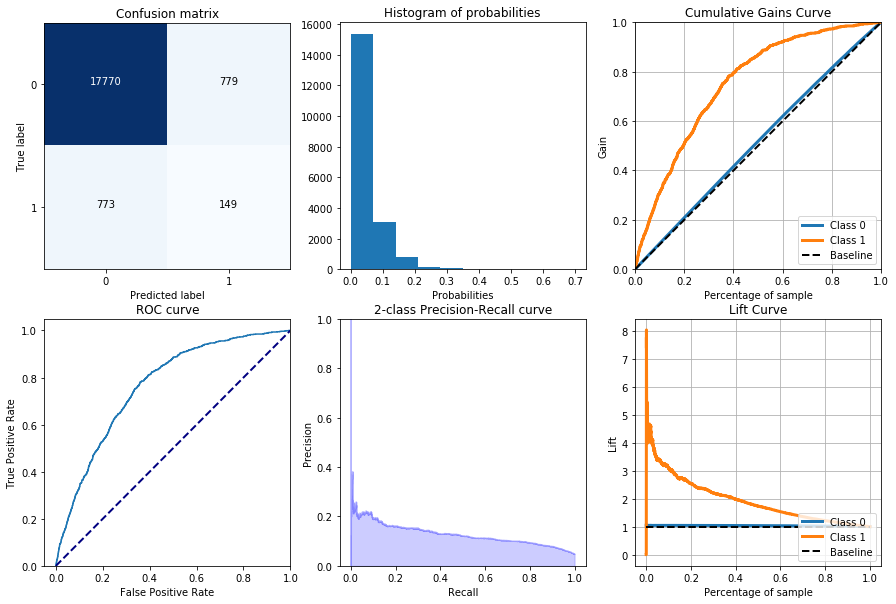

In [18]:
lr_t = LogisticRegression()

lr_model_t, t_prob = evaluate_clf(lr_t, X_train_t_sc, y_train_t, X_val_t_sc, y_val_t)

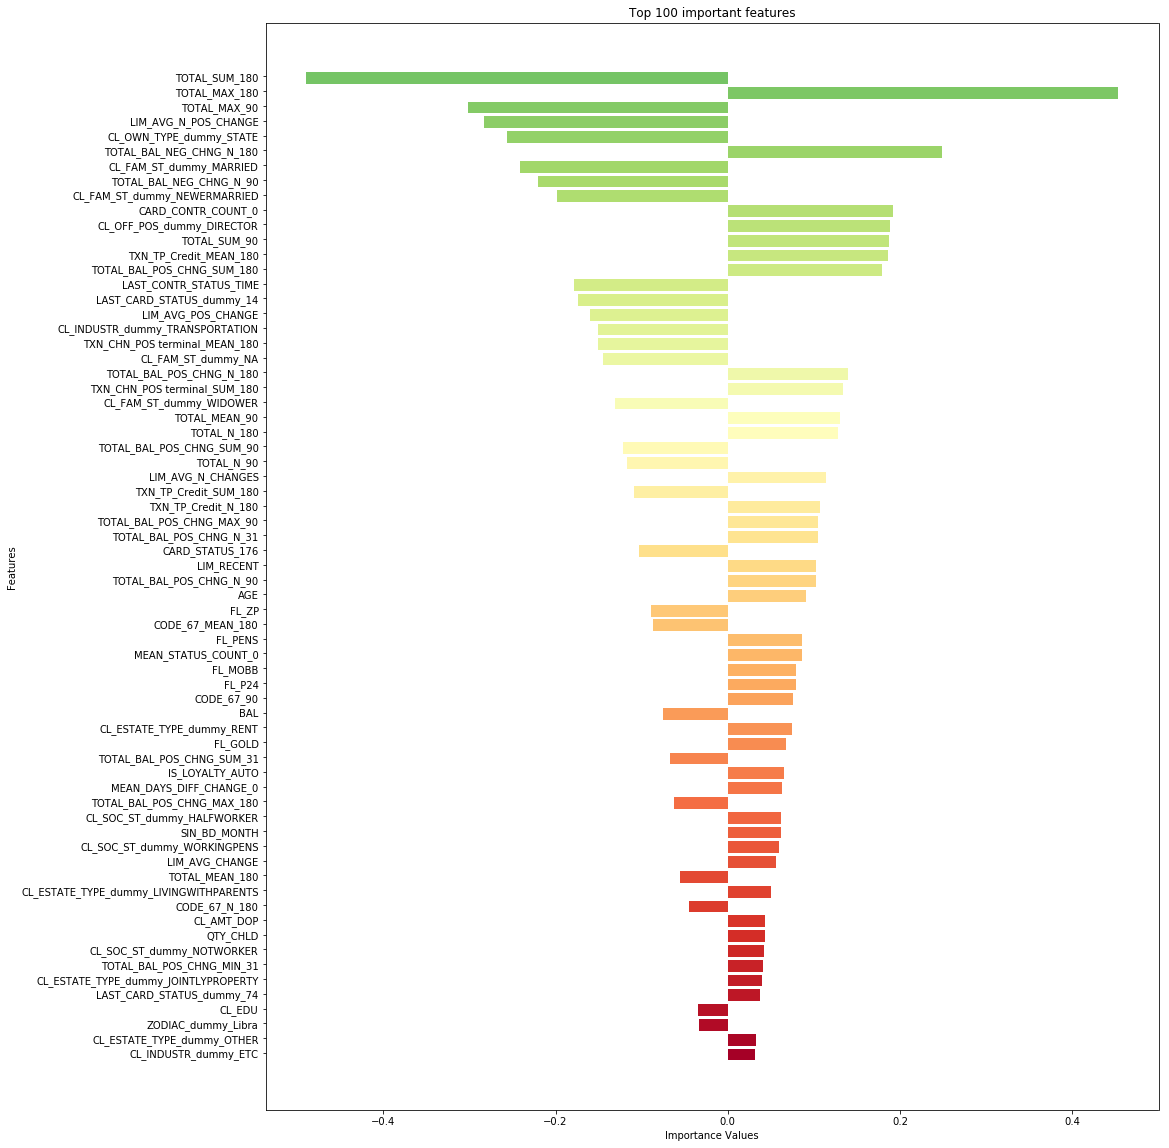

In [19]:
importances = pd.DataFrame(data={
    'features': X_train_t.columns,
    'fscore': lr_model_t.coef_[0]
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

## Оценим UPLIFT

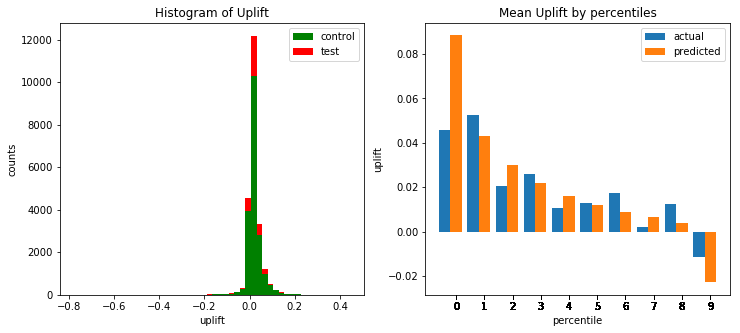

In [20]:
evaluate['sent'] = lr_model_t.predict_proba(X_val_sc.drop(['CONTROL_GROUP_FLG'], axis=1))[:, 1]
evaluate['not_sent'] = lr_model_c.predict_proba(X_val_sc.drop(['CONTROL_GROUP_FLG'], axis=1))[:, 1]
evaluate['uplift'] = evaluate['sent'] - evaluate['not_sent']

evaluate['predict'] = np.floor(evaluate.uplift.rank(method='first', ascending = False) /\
                                            (evaluate.shape[0]+1) * 10)

eval_actual = pd.crosstab(index=evaluate['predict'].astype(int), columns=evaluate['CONTROL_GROUP_FLG'], 
            values=evaluate['TARGET'], aggfunc='mean')
eval_actual['uplift'] = eval_actual[0] - eval_actual[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].title.set_text('Histogram of Uplift')
axes[0].hist([evaluate[evaluate['CONTROL_GROUP_FLG']==0]['uplift'],
          evaluate[evaluate['CONTROL_GROUP_FLG']==1]['uplift']],
         stacked=True, label=['control', 'test'], bins=50, color=['g', 'r'])
axes[0].set_xlabel('uplift')
axes[0].set_ylabel('counts')
axes[0].legend()


axes[1].bar(eval_actual.index-0.4, eval_actual['uplift'], label='actual', width = 0.4)
axes[1].bar(evaluate.groupby('predict').mean().index, 
        evaluate.groupby('predict').mean()['uplift'], label='predicted', width=0.4)
axes[1].set_xticks(evaluate['predict'])
axes[1].set_xlabel('percentile')
axes[1].set_ylabel('uplift')
axes[1].legend()
axes[1].title.set_text('Mean Uplift by percentiles')

In [21]:
eval_actual

CONTROL_GROUP_FLG,0,1,uplift
predict,,,
0,0.129199,0.083565,0.045634
1,0.090057,0.037534,0.052524
2,0.052165,0.031746,0.020419
3,0.049266,0.023316,0.025950
4,0.025128,0.014493,0.010635
5,0.025784,0.012658,0.013125
6,0.020093,0.002825,0.017268
7,0.010331,0.008380,0.001951
8,0.012607,0.000000,0.012607


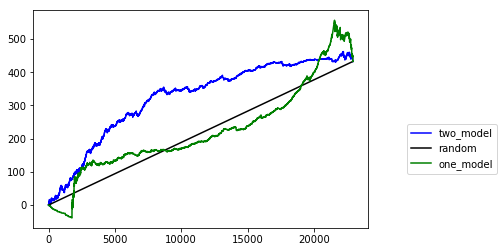

In [22]:
two_mod_uc = uplift(evaluate, 'CONTROL_GROUP_FLG', 'TARGET', 'uplift')

plt.plot(np.arange(evaluate.shape[0]), two_mod_uc, color = 'b', label = 'two_model')
plt.plot(np.arange(evaluate.shape[0]), rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), one_mod_uc, color = 'g', label = 'one_model')
plt.legend(bbox_to_anchor=(1.4, 0.5))

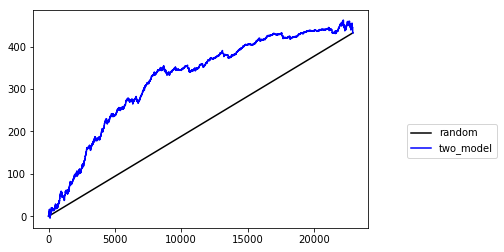

In [23]:
plt.plot(np.arange(evaluate.shape[0]),rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), two_mod_uc, color = 'b', label = 'two_model')
plt.legend(bbox_to_anchor=(1.4, 0.5))

In [33]:
two_mod_uc[:5000].mean()

122.58696764009372

# 3 Подход "Class Modification"

In [24]:
df['modified_outcome'] = df['TARGET'] * (1 - df['CONTROL_GROUP_FLG'].map({'N': 0, 'Y': 1})) \
                                 + (1-df['TARGET']) * df['CONTROL_GROUP_FLG'].map({'N': 0, 'Y': 1})

Данный подход требует, чтобы объем контрольной и тестовой групп был одинаков. Поэтому для достижения результатов произведем undersamplimg:

In [25]:
df_modify = pd.concat([
    df[df['CONTROL_GROUP_FLG']=='N'].sample(n=df[df['CONTROL_GROUP_FLG']=='Y'].shape[0],
                                        random_state=555),
    df[df['CONTROL_GROUP_FLG']=='Y']
])

In [27]:
Xy_train, Xy_val = train_test_split(
    df_modify, 
    test_size=0.2, 
    random_state=42, stratify=df_modify['modified_outcome'])

d = Dummyfier(dummy, drop_old=True)

scaler = StandardScaler()

Xy_train = prepare(Xy_train)
Xy_train = d.fit_transform(Xy_train)

na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
Xy_train = Xy_train.fillna(value=X_train[na_cols_train].mean())

Xy_val = prepare(Xy_val)
Xy_val = d.transform(Xy_val)

na_cols_val = Xy_val.isna().any()
na_cols_val = na_cols_val[na_cols_val==True].index.tolist()
Xy_val = Xy_val.fillna(value=Xy_val[na_cols_val].mean())

y_train, y_val = Xy_train['modified_outcome'].values.flatten(), Xy_val['modified_outcome'].values.flatten()

X_train = Xy_train.drop(['modified_outcome', 'TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)
X_val = Xy_val.drop(['modified_outcome', 'TARGET', 'CONTROL_GROUP_FLG'] + identity, axis=1)

X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

                 train     valid
ROC AUC       0.585754  0.568413
Av Precision  0.581788  0.563763
logloss       0.682177  0.688101
Accuracy      0.566833  0.556295
Precision     0.575622  0.565230
Precision@10  0.625996  0.602899
Recall        0.575581  0.565230
F1            0.575602  0.565230
F0.5          0.575614  0.565230
F2            0.575590  0.565230


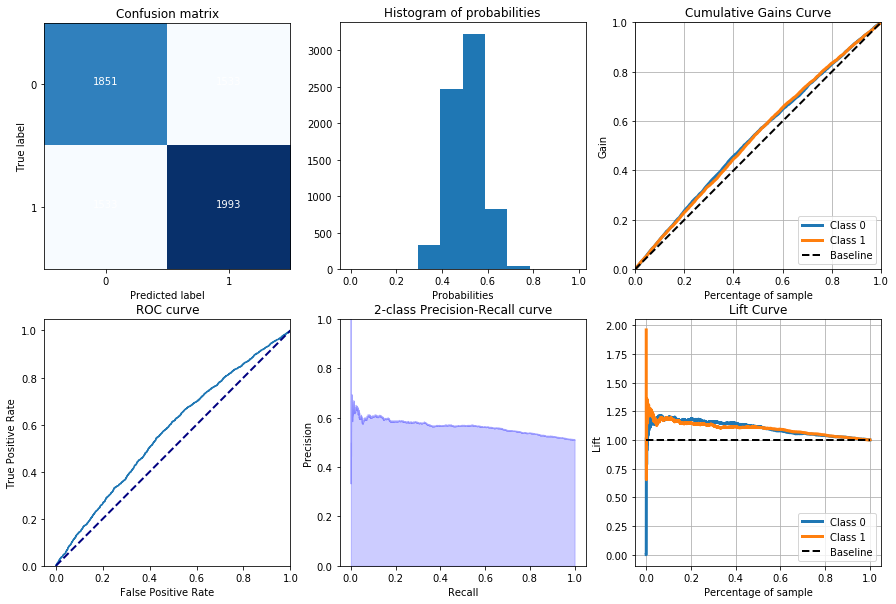

In [28]:
lr = LogisticRegression()

lr_model, _ = evaluate_clf(lr, X_train, y_train, X_val, y_val)

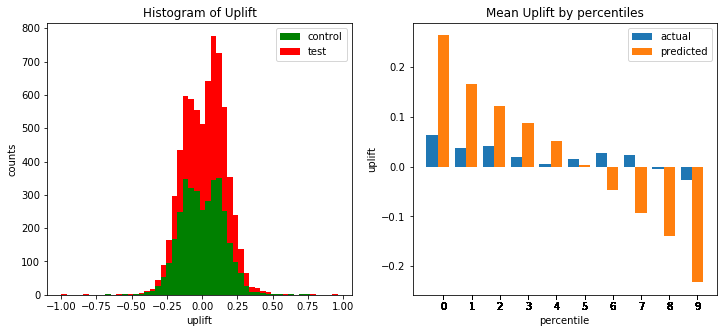

In [29]:
evaluate = Xy_val.copy()
evaluate = evaluate.assign(uplift=(2*(lr_model.predict_proba(X_val)[:,1]) - 1))

evaluate['predict'] = np.floor(evaluate.uplift.rank(method='first', ascending = False) /\
                                            (evaluate.shape[0]+1) * 10)

eval_actual = pd.crosstab(index=evaluate['predict'].astype(int), columns=evaluate['CONTROL_GROUP_FLG'], 
            values=evaluate['TARGET'], aggfunc='mean')
eval_actual['uplift'] = eval_actual[0] - eval_actual[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].title.set_text('Histogram of Uplift')
axes[0].hist([evaluate[evaluate['CONTROL_GROUP_FLG']==0]['uplift'],
          evaluate[evaluate['CONTROL_GROUP_FLG']==1]['uplift']],
         stacked=True, label=['control', 'test'], bins=50, color=['g', 'r'])
axes[0].set_xlabel('uplift')
axes[0].set_ylabel('counts')
axes[0].legend()


axes[1].bar(eval_actual.index-0.4, eval_actual['uplift'], label='actual', width = 0.4)
axes[1].bar(evaluate.groupby('predict').mean().index, 
        evaluate.groupby('predict').mean()['uplift'], label='predicted', width=0.4)
axes[1].set_xticks(evaluate['predict'])
axes[1].set_xlabel('percentile')
axes[1].set_ylabel('uplift')
axes[1].legend()
axes[1].title.set_text('Mean Uplift by percentiles')

In [30]:
eval_actual

CONTROL_GROUP_FLG,0,1,uplift
predict,,,
0,0.096552,0.032419,0.064133
1,0.058442,0.020888,0.037554
2,0.052960,0.010811,0.042149
3,0.054140,0.034483,0.019657
4,0.036066,0.031088,0.004977
5,0.070175,0.054441,0.015734
6,0.051414,0.023179,0.028235
7,0.038860,0.016393,0.022467
8,0.032663,0.037543,-0.004879


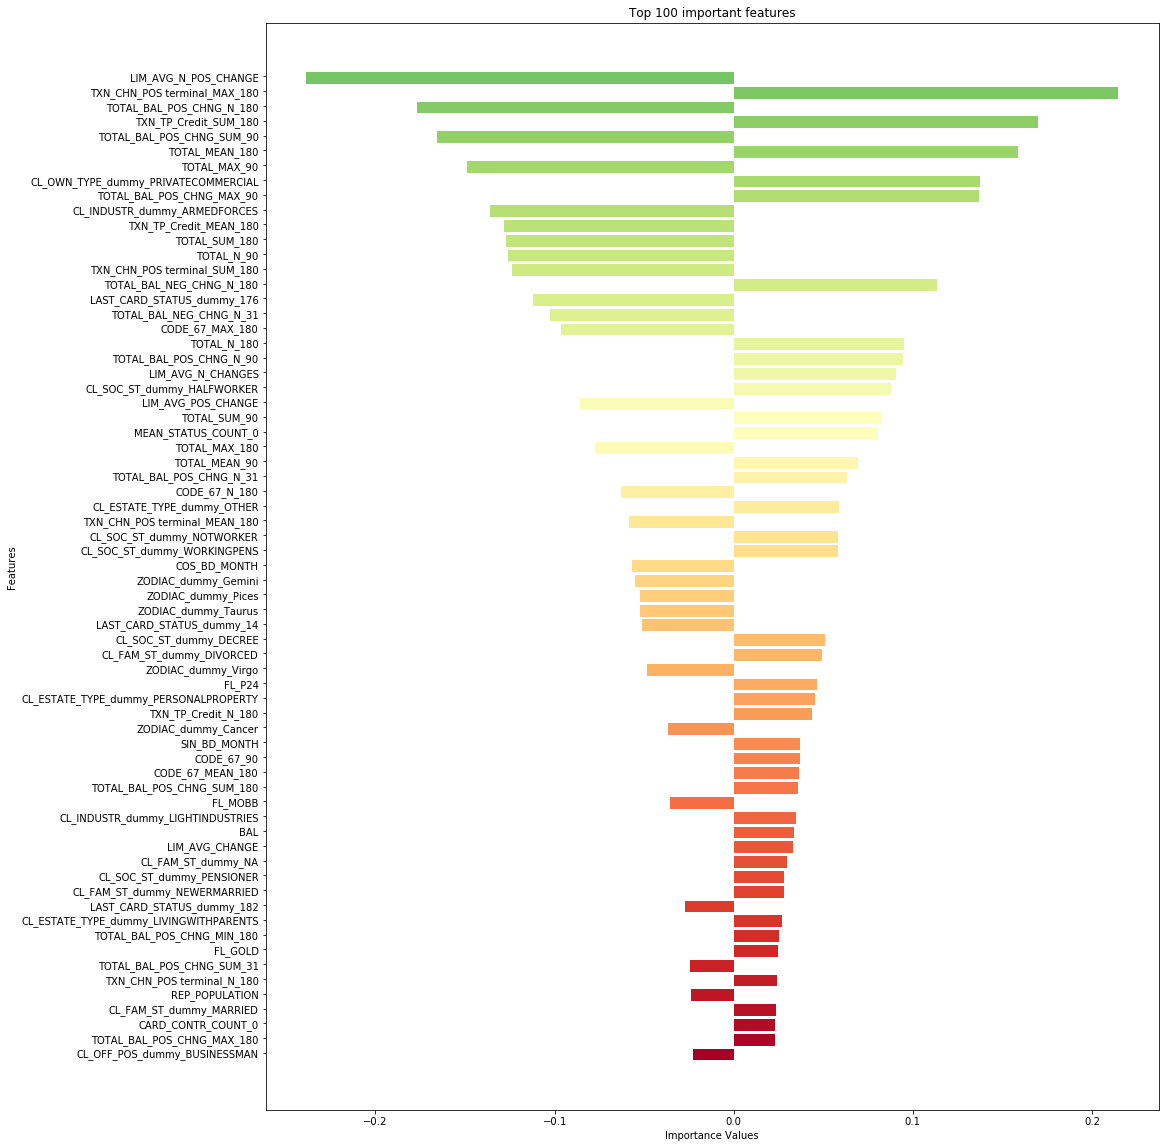

In [31]:
importances = pd.DataFrame(data={
    'features': X_train.columns,
    'fscore': lr_model.coef_[0]
})

# сортируем по абсолютному значению поля fscore
importances = importances.reindex(importances.fscore.abs().sort_values().index)

f_names, f_values = importances['features'].tail(100), importances['fscore'].tail(100)
## all columns from [st_idx : end_idx] will be plotted
## the higher the index, the more important the feature
st_idx = int(len(f_names) / 3); end_idx = int(len(f_names) / 1);

fig = plt.figure(figsize=(16, 20))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')

plt.title('Top 100 important features')
plt.show()

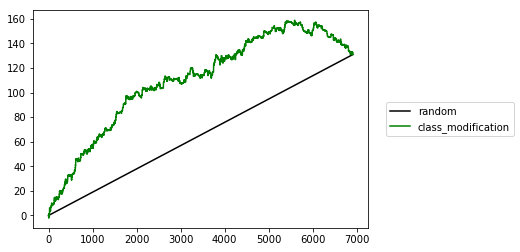

In [32]:
class_m_uc = uplift(evaluate, 'CONTROL_GROUP_FLG', 'TARGET', 'uplift')

rd_uc = (evaluate[evaluate['CONTROL_GROUP_FLG']==0]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==0].shape[0]
        - evaluate[evaluate['CONTROL_GROUP_FLG']==1]['TARGET'].sum() / evaluate[evaluate['CONTROL_GROUP_FLG']==1].shape[0])
rd = np.arange(evaluate.shape[0]) * rd_uc

plt.plot(np.arange(evaluate.shape[0]), rd, color = 'k', label = 'random')
plt.plot(np.arange(evaluate.shape[0]), class_m_uc, color = 'g', label = 'class_modification')
plt.legend(bbox_to_anchor=(1.45, 0.6))